In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



## Reading the Datasets

In [2]:
df = pd.read_csv('train.csv')
df.shape[0]

404290

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


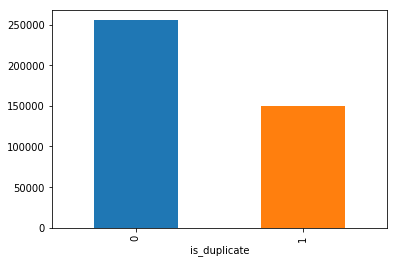

In [28]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [29]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

### Finding Unique number of Questions

In [30]:
questions = pd.Series(df.qid1.tolist() + df.qid2.tolist())
unique  = questions.unique()
print ('So there are total of {} questions in the given dataset.'.format(unique.shape[0]))


So there are total of 537933 questions in the given dataset.


In [31]:
uni = len(np.unique(questions))
more_than_one = np.sum(questions.value_counts() > 1)
k = max(questions.value_counts())
k1 = questions[k]
k1


print('Number of unique questions repeated more than once is {}.\n'.format(more_than_one))


print('Question id {} is repeated {} times, which is maximum.\n'.format(k,k1))

Number of unique questions repeated more than once is 111780.

Question id 157 is repeated 315 times, which is maximum.



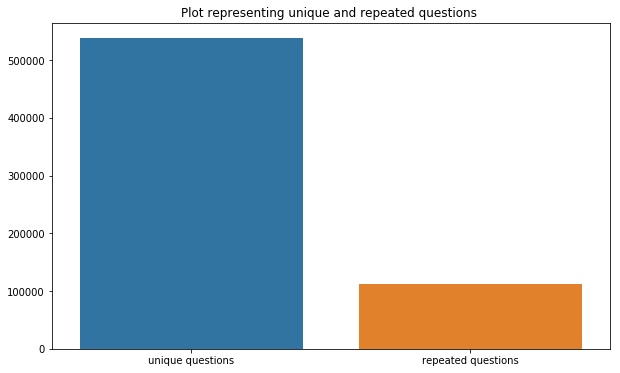

In [32]:
x = ["unique questions","repeated questions"]
y = [uni , more_than_one]

plt.figure(figsize = (10,6))
plt.title("Plot representing unique and repeated questions ")
sns.barplot(x,y)
plt.show()

### Checking for pairwise duplicates

In [33]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print("Number of duplicate pair questions",pair_duplicates.shape[0] - df.shape[0])

Number of duplicate pair questions 0


Text(0,0.5,'Number of questions')

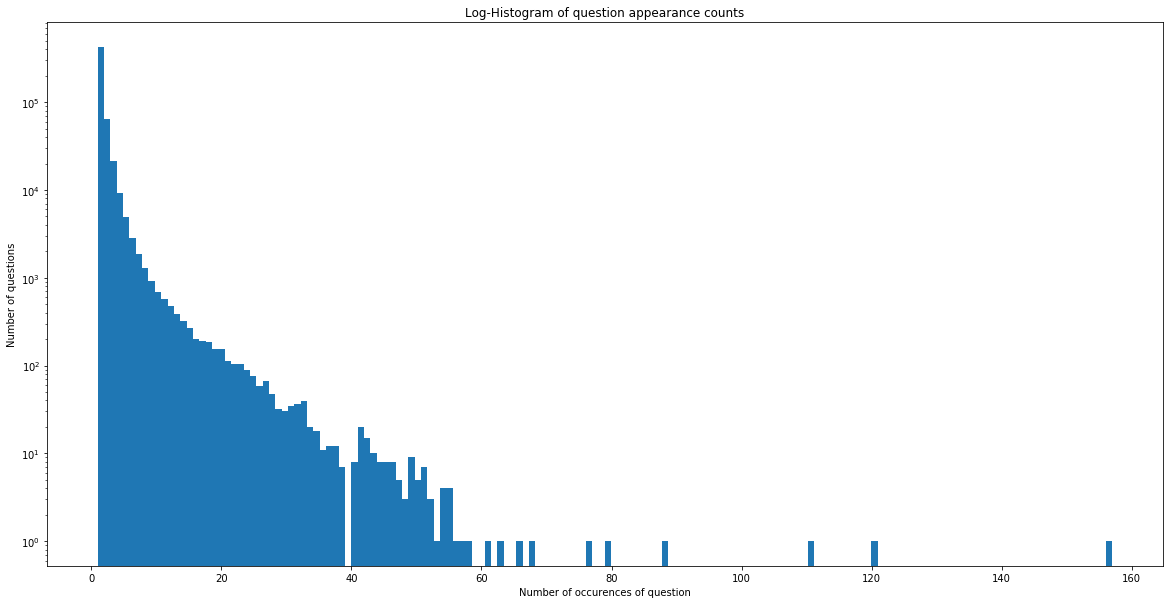

In [34]:
plt.figure(figsize=(20, 10))

plt.hist(questions.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

### Finding Null Records

In [35]:
df_null = df[df.isnull().any(1)]
df_null

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [36]:
df = df.fillna('')

### Basic Feature Extraction 

In [37]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    

In [38]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


In [39]:
k1 = "Ram is a good boy, he goes to school everyday ."
k2 = "Shyam is Ram friend , they go to the same school ."


w1 = set(map(lambda word : word.lower().strip(),k1.split(" ") ))
w2 = set(map(lambda word : word.lower().strip(),k2.split(" ") ))
len(w1 & w2)

5

In [40]:
def common_words (row):
    w1 = set(map(lambda word : word.lower().strip(),row['question1'].split(" ") ))
    w2 = set(map(lambda word : word.lower().strip(),row['question2'].split(" ") ))
    return 1.0 * len(w1 & w2)


df['common_words'] = df.apply(common_words,axis = 1)


def total_words (row):
    w1 = set(map(lambda word : word.lower().strip(),row['question1'].split(" ") ))
    w2 = set(map(lambda word : word.lower().strip(),row['question2'].split(" ") ))
    return 1.0 * (len(w1) + len(w2))


df['total_words'] = df.apply(total_words,axis = 1)


def word_share (row):
    w1 = set(map(lambda word : word.lower().strip(),row['question1'].split(" ") ))
    w2 = set(map(lambda word : word.lower().strip(),row['question2'].split(" ") ))
    return 1.0 * (len(w1 & w2)/(len(w1) + len(w2)))


df['word_share'] = df.apply(word_share ,axis = 1)

In [41]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,common_words,total_words,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000


#### Quick Analysis of new features

In [42]:
print('Smallest question in quest1 =',min(df['q1_n_words']))

print('Smallest question in quest2 =',min(df['q2_n_words']))

print('Number of question1 with min length =',df[df['q1_n_words']==min(df['q1_n_words'])].shape[0])

print('Number of question2 with min length =',df[df['q2_n_words']==min(df['q2_n_words'])].shape[0])

Smallest question in quest1 = 1
Smallest question in quest2 = 1
Number of question1 with min length = 67
Number of question2 with min length = 24


#### Feature Analysis : Word Share

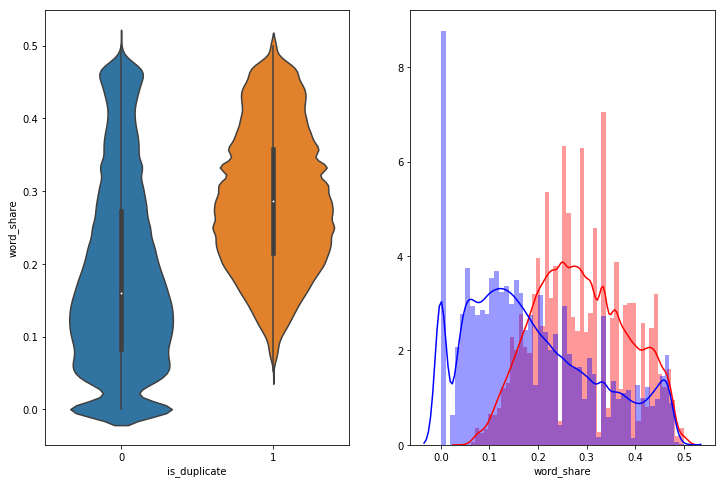

In [43]:
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate',y = 'word_share',data = df[0:])


plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

#### Feature Analysis : Common Words

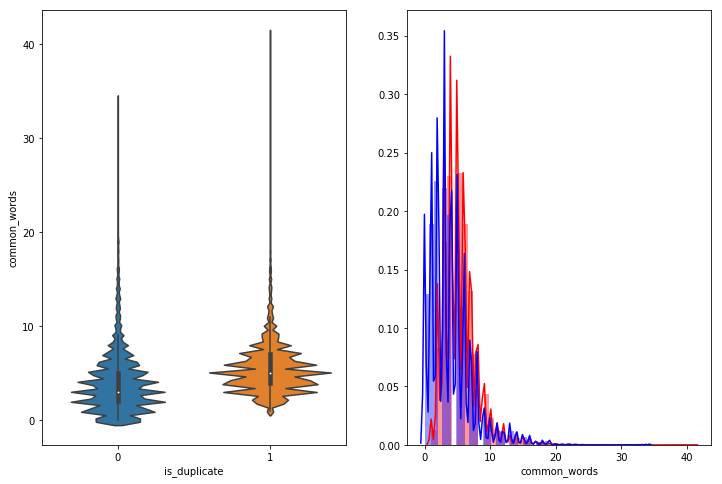

In [44]:
%%time
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate',y = 'common_words',data = df[0:])


plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['common_words'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['common_words'][0:] , label = "0" , color = 'blue' )
plt.show()

##### Here we can see that the violin plot and distribution of two classes for this feature almost overlaps each other.Having said that this variable may not be that important for prediciting binary input.

### Text Preprocessing Step

Here we will be removing some of the irregualrities from both questions 1 question 2 like

    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [62]:
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [84]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

### Advance Feature Extraction

In [85]:
df2 = extract_features(df) 

token features...
fuzzy features..


In [88]:
df2=df
df2.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,token_partial_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.0,1.0,2.0,13.0,100,93,93,100,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.0,1.0,5.0,12.5,86,63,66,75,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.0,1.0,4.0,12.0,63,63,43,47,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.0,0.0,2.0,12.0,28,24,9,14,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.0,1.0,6.0,10.0,67,47,35,56,56,0.175000


### Analysis of extracted features 

###### Plotting word clouds

In [91]:
df_duplicate = df[df['is_duplicate']== 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

p = np.dstack([df_duplicate['question1'],df_duplicate['question2']]).flatten()
n = np.dstack([df_nonduplicate['question1'],df_nonduplicate['question2']]).flatten()

print('Number of data points in class 1 (duplicate pairs) :', len(p))
print('Number of data points in class 0 (non duplicate pairs) :', len(n))

np.savetxt('train_p.txt',p,delimiter=' ',fmt='%s')
np.savetxt('train_n.txt',n,delimiter=' ',fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [93]:
#Removing all the stop words:

d = path.dirname('.')

textp_w = open(path.join(d,'train_p.txt')).read()
textn_w = open(path.join(d,'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109860
Total number of words in non duplicate pair questions : 33192946


___Word Clouds generated from duplicate pair question's text

Word Cloud for doplicate Question pairs


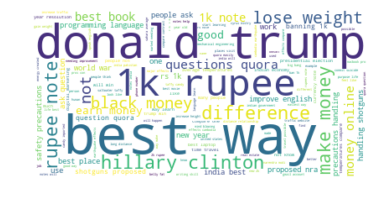

In [96]:
wc = WordCloud(background_color ="white",max_words=len(textp_w),stopwords=stopwords)
wc.generate(textp_w)
print('Word Cloud for duplicate Question pairs')
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off")
plt.show()

 __Word Cloud generated for non-duplicate Question pairs

Word Cloud for non duplicate Question pairs


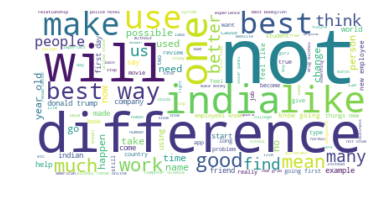

In [97]:
wc = WordCloud(background_color ="white",max_words=len(textn_w),stopwords=stopwords)
wc.generate(textn_w)
print('Word Cloud for non duplicate Question pairs')
plt.imshow(wc,interpolation = 'bilinear')
plt.axis("off")
plt.show()

#### Bivariate plotting of several advance feature extracted

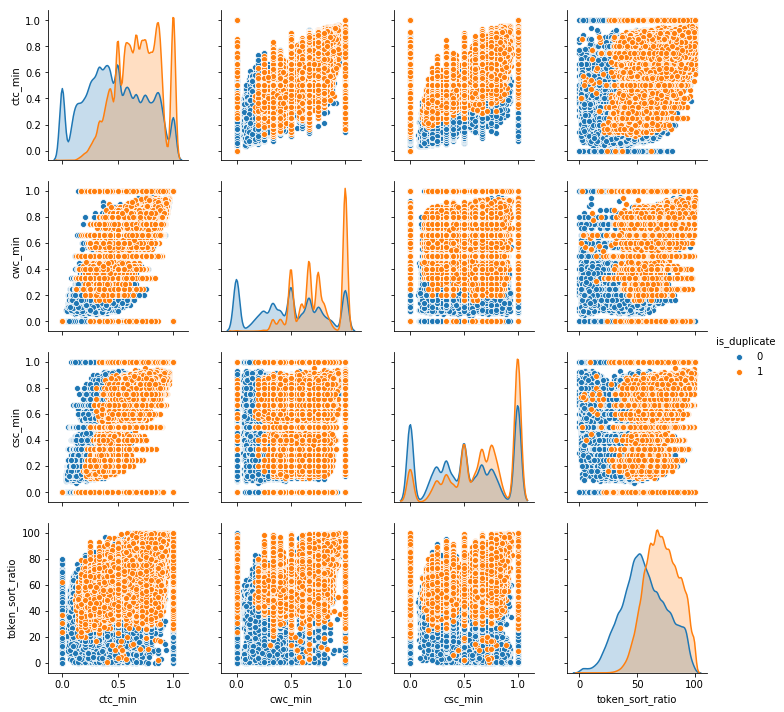

In [101]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n],hue ='is_duplicate',vars = ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

__Here in the case of token sort ratio vs rest 3 features, we can see there is a slight sense seperation in the classes of datapoints.
So we have decided to go with univariate analysis

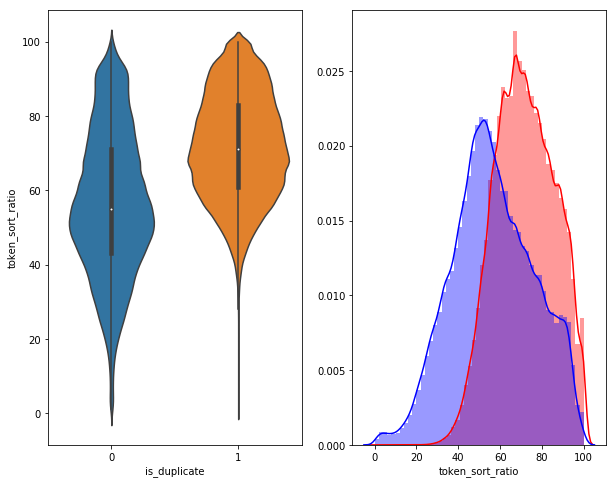

In [102]:
#Distribution of token sort ratio
plt.figure(figsize =(10,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='token_sort_ratio',data = df[0:],)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:],label ="1",color = "red")
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:],label ="0",color = "blue")

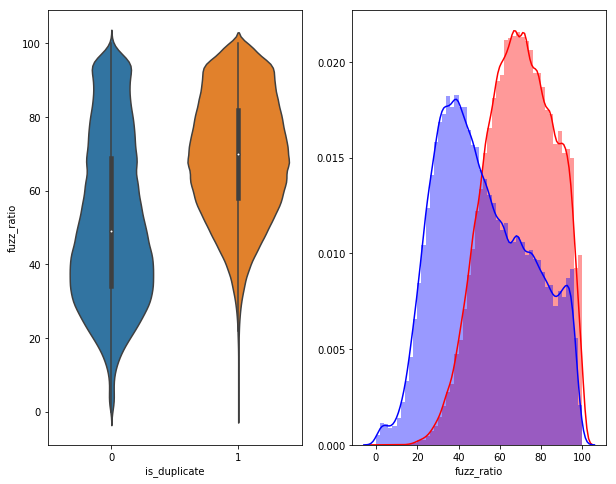

In [103]:
#Distribution of fuzz ratio
plt.figure(figsize =(10,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='fuzz_ratio',data = df[0:],)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:],label ="1",color = "red")
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:],label ="0",color = "blue")

### Visulization using all relevant features

In [104]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X= MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y= dfp_subsampled['is_duplicate'].values
                                                

In [105]:
tsne2d = TSNE(
    n_components=2,
    init = 'random',
    random_state = 32,
    method = 'barnes_hut',
    n_iter=1000,
    verbose = 2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.020s...
[t-SNE] Computed neighbors for 5000 samples in 0.356s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.196s
[t-SNE] Iteration 50: error = 81.5828171, gradient norm = 0.0477268 (50 iterations in 5.693s)
[t-SNE] Iteration 100: error = 70.4573517, gradient norm = 0.0100400 (50 iterations in 4.437s)
[t-SNE] Iteration 150: error = 68.6631622, gradient norm = 0.0053364 (50 iterations in 4.187s)
[t-SNE] Iteration 200: error = 67.8457031, gradient norm = 0.0040470 (50 iterations in 4.157s)
[t-SNE] Iteration 250: error = 67.3985443, gradient norm = 0.0035687

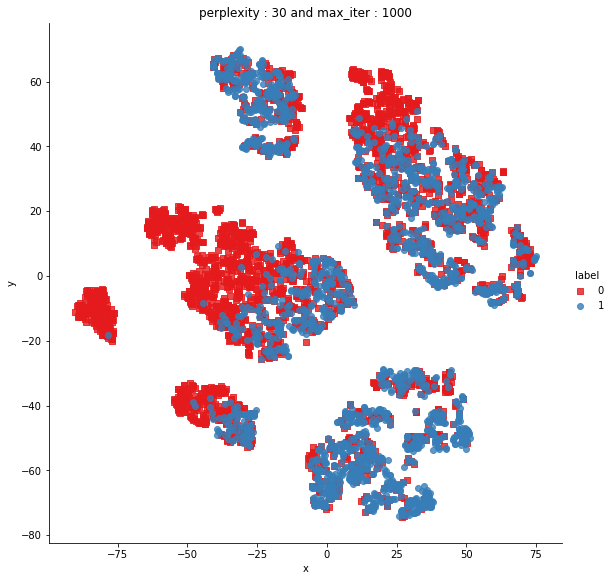

In [106]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [107]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.330s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.159s
[t-SNE] Iteration 50: error = 80.5298615, gradient norm = 0.0306586 (50 iterations in 11.017s)
[t-SNE] Iteration 100: error = 69.3777008, gradient norm = 0.0037944 (50 iterations in 5.721s)
[t-SNE] Iteration 150: error = 67.9726028, gradient norm = 0.0017517 (50 iterations in 5.196s)
[t-SNE] Iteration 200: error = 67.4098892, gradient norm = 0.0013384 (50 iterations in 5.876s)
[t-SNE] Iteration 250: error = 67.0977859, gradient norm = 0.000959

In [110]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

### <h2> Featurizing text data with tfidf weighted word-vectors </h2>

In [3]:
#Importing other important libs

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import spacy

In [36]:
df['question1'] = df['question1'].apply(lambda x:str(x))
df['question2'] = df['question2'].apply(lambda x:str(x))
df['question2'].head()

0    What is the step by step guide to invest in sh...
1    What would happen if the Indian government sto...
2    How can Internet speed be increased by hacking...
3    Find the remainder when [math]23^{24}[/math] i...
4              Which fish would survive in salt water?
Name: question2, dtype: object

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#merge texts

questions = list(df['question1'])+list(df['question2'])
tfidf = TfidfVectorizer(lowercase = False,)
tfidf.fit_transform(questions)

#dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(),tfidf.idf_))

In [6]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []

for q1 in tqdm(list(df['question1'])):
    doc1 = nlp(q1)
    
    # Dimension of the vector is 384
    
    mean_vec1 = np.zeros([len(doc1),len(doc1[0].vector)])
    for word1 in doc1:
        
        #word2vec
        vec1 = word1.vector
        
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1*idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 404290/404290 [1:10:59<00:00, 94.91it/s]


In [33]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec1 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 404290/404290 [1:01:00<00:00, 110.44it/s]


In [34]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"[121.92995071411133, 100.08389639854431, 72.49...",49883.359375
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"[-78.0709376335144, 54.843778640031815, 82.738...",49884.453125
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"[-5.355007767677307, 73.67180120944977, 14.376...",49884.253906
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"[5.778360903263092, -34.71202936768532, 48.999...",49884.292969
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"[51.13820472359657, 38.5873201712966, 123.6395...",49884.417969


12.99359822607572

In [15]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")
                        
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [21]:
dfppro.shape

(404290, 17)

In [22]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [28]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,121.929951,100.083896,72.497917,115.641820,-48.370852,34.619079,-172.057780,-92.502610,113.223287,50.562427,...,12.397650,40.909514,8.150258,-15.170691,18.007709,6.167001,-30.124163,3.700892,-1.757698,-1.818057
1,-78.070938,54.843779,82.738470,98.191876,-51.234853,55.013512,-39.140759,-82.692363,45.161505,-9.556295,...,-21.987070,-12.389282,20.667985,2.202720,-17.142447,-5.880974,-10.123963,-4.890663,-13.018392,-5.219308
2,-5.355008,73.671801,14.376384,104.130266,1.433535,35.229134,-148.519403,-97.124592,41.972222,50.948716,...,3.027713,14.025766,-2.960312,-3.206544,4.355138,2.936153,-20.199557,9.816348,11.894362,-8.798818
3,5.778361,-34.712029,48.999642,59.699220,40.661260,-41.658745,-36.808582,24.170645,0.235597,-29.407289,...,13.100011,1.405663,-1.891077,-7.882641,18.000560,12.106917,-10.507834,5.243826,10.158341,5.886352
4,51.138205,38.587320,123.639506,53.333008,-47.062758,37.356215,-298.722764,-106.421141,106.248893,65.880698,...,13.906540,43.461691,11.519201,-22.468287,45.431116,8.161226,-35.373910,7.728850,9.592848,5.447334


In [29]:
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [30]:
df3.head()

,id,q1_feats_m,q2_feats_m
0,0,"[121.92995071411133, 100.08389639854431, 72.49...",-0.451992
1,1,"[-78.0709376335144, 54.843778640031815, 82.738...",0.642708
2,2,"[-5.355007767677307, 73.67180120944977, 14.376...",0.443707
3,3,"[5.778360903263092, -34.71202936768532, 48.999...",0.482311
4,4,"[51.13820472359657, 38.5873201712966, 123.6395...",0.608458


In [31]:
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,121.929951,100.083896,72.497917,115.641820,-48.370852,34.619079,-172.057780,-92.502610,113.223287,50.562427,...,12.397650,40.909514,8.150258,-15.170691,18.007709,6.167001,-30.124163,3.700892,-1.757698,-1.818057
1,-78.070938,54.843779,82.738470,98.191876,-51.234853,55.013512,-39.140759,-82.692363,45.161505,-9.556295,...,-21.987070,-12.389282,20.667985,2.202720,-17.142447,-5.880974,-10.123963,-4.890663,-13.018392,-5.219308
2,-5.355008,73.671801,14.376384,104.130266,1.433535,35.229134,-148.519403,-97.124592,41.972222,50.948716,...,3.027713,14.025766,-2.960312,-3.206544,4.355138,2.936153,-20.199557,9.816348,11.894362,-8.798818
3,5.778361,-34.712029,48.999642,59.699220,40.661260,-41.658745,-36.808582,24.170645,0.235597,-29.407289,...,13.100011,1.405663,-1.891077,-7.882641,18.000560,12.106917,-10.507834,5.243826,10.158341,5.886352
4,51.138205,38.587320,123.639506,53.333008,-47.062758,37.356215,-298.722764,-106.421141,106.248893,65.880698,...,13.906540,43.461691,11.519201,-22.468287,45.431116,8.161226,-35.373910,7.728850,9.592848,5.447334


In [35]:
df3_q2.head()

,0
0,-0.451992
1,0.642708
2,0.443707
3,0.482311
4,0.608458
